# Time Series Coding Assignment

In [1]:
# importing the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

#### Download three data series from FRED (The St. Louis Fed’s Economic Database) and import into a Python Pandas Dataframe.

In [2]:
# downloading the datasets
inflation = pd.read_csv(r"C:/Users/akudu/Downloads/GDPCTPI.csv")
unemployment = pd.read_csv(r"C:/Users/akudu/Downloads/UNRATE.csv")
fed_rate = pd.read_csv(r"C:/Users/akudu/Downloads/DFF.csv")

In [3]:
df = pd.concat([inflation, unemployment, fed_rate], axis=1)

In [4]:
df

,DATE,GDPCTPI,DATE,UNRATE,DATE,DFF
0,1960-01-01,15.402,1960-01-01,5.133333,1960-01-01,3.931319
1,1960-04-01,15.457,1960-04-01,5.233333,1960-04-01,3.695055
2,1960-07-01,15.524,1960-07-01,5.533333,1960-07-01,2.937500
3,1960-10-01,15.592,1960-10-01,6.266667,1960-10-01,2.296196
4,1961-01-01,15.610,1961-01-01,6.800000,1961-01-01,1.987556
...,...,...,...,...,...,...
251,2022-10-01,120.115,2022-10-01,3.600000,2022-10-01,3.653370
252,2023-01-01,121.264,2023-01-01,3.500000,2023-01-01,4.514556
253,2023-04-01,121.789,2023-04-01,3.566667,2023-04-01,4.988132
254,2023-07-01,122.846,2023-07-01,3.700000,2023-07-01,5.259239


In [5]:
# Drop two of the identical columns
merged_df = df.loc[:, ~df.columns.duplicated()]
merged_df

,DATE,GDPCTPI,UNRATE,DFF
0,1960-01-01,15.402,5.133333,3.931319
1,1960-04-01,15.457,5.233333,3.695055
2,1960-07-01,15.524,5.533333,2.937500
3,1960-10-01,15.592,6.266667,2.296196
4,1961-01-01,15.610,6.800000,1.987556
...,...,...,...,...
251,2022-10-01,120.115,3.600000,3.653370
252,2023-01-01,121.264,3.500000,4.514556
253,2023-04-01,121.789,3.566667,4.988132
254,2023-07-01,122.846,3.700000,5.259239


#### Make sure the variables are in this order (inflation, unemployment, fed funds) in your dataframe. This matters for the recursive ordering in the VAR estimation.

In [6]:
merged_df.columns = ['DATE', 'PI', 'UNEMPLOYMENT','FED FUNDS']
merged_df

,DATE,PI,UNEMPLOYMENT,FED FUNDS
0,1960-01-01,15.402,5.133333,3.931319
1,1960-04-01,15.457,5.233333,3.695055
2,1960-07-01,15.524,5.533333,2.937500
3,1960-10-01,15.592,6.266667,2.296196
4,1961-01-01,15.610,6.800000,1.987556
...,...,...,...,...
251,2022-10-01,120.115,3.600000,3.653370
252,2023-01-01,121.264,3.500000,4.514556
253,2023-04-01,121.789,3.566667,4.988132
254,2023-07-01,122.846,3.700000,5.259239


In [7]:
merged_df.isnull().sum()

DATE            1
PI              1
UNEMPLOYMENT    1
FED FUNDS       0
dtype: int64

In [8]:
merged_df = merged_df.dropna()

In [9]:
merged_df.isnull().sum()

DATE            0
PI              0
UNEMPLOYMENT    0
FED FUNDS       0
dtype: int64

#### Best practice is to check for stationarity (Using AD Fuller's Test)

$H0:$ Variable is not Stationary

$H1:$ Variable is Stationary

In [10]:
ad_fuller_result_1 = adfuller(merged_df['PI'])
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

ad_fuller_result_2 = adfuller(merged_df['UNEMPLOYMENT'])
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ad_fuller_result_3 = adfuller(merged_df['FED FUNDS'])
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')


ADF Statistic: 1.238684989424051
p-value: 0.9962425591085008
ADF Statistic: -3.377527596113789
p-value: 0.01174922991946032
ADF Statistic: -2.1147014315011585
p-value: 0.23864432016347586


#### We fail to reject the null hypothesis and hence all variables are non-stationary.

In [11]:
ad_fuller_result_1 = adfuller(merged_df['PI'].diff()[1:])
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

ad_fuller_result_2 = adfuller(merged_df['UNEMPLOYMENT'].diff()[1:])
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ad_fuller_result_3 = adfuller(merged_df['FED FUNDS'].diff()[1:])
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')


ADF Statistic: -1.1200745945535715
p-value: 0.7070003608623843
ADF Statistic: -16.84536853898719
p-value: 1.1295962660818982e-29
ADF Statistic: -6.830367435159505
p-value: 1.9005221087548174e-09


#### As we can see from the p-values, Unemployment and Fed Funds Rate variables have been stationarized. It is possible to stationarize PI values as well if we take a second order differentiation.

#### 2. Calculate the inflation rate. You can do this calculation either in Excel or after importing to Python

***Inflation Rate Eqn:***$$πt = 400 ln(Pt /Pt−1)$$

In [12]:
# Manual Formula
# Create a new column for inflation rates
merged_df['INFLATION RATE'] = 400 * np.log(merged_df['PI'] / merged_df['PI'].shift(1))

C:\Users\akudu\AppData\Local\Temp\ipykernel_16088\3310230423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['INFLATION RATE'] = 400 * np.log(merged_df['PI'] / merged_df['PI'].shift(1))


The method $$df[col].shift(i)$$ is a convenient way to obtain the i-th lag of any feature.

In [ ]:
merged_df = merged_df.set_index('DATE')

In [14]:
merged_df

,PI,UNEMPLOYMENT,FED FUNDS,INFLATION RATE
DATE,,,,
1960-01-01,15.402,5.133333,3.931319,NaN
1960-04-01,15.457,5.233333,3.695055,1.425842
1960-07-01,15.524,5.533333,2.937500,1.730095
1960-10-01,15.592,6.266667,2.296196,1.748299
1961-01-01,15.610,6.800000,1.987556,0.461509
...,...,...,...,...
2022-07-01,118.980,3.566667,2.182935,4.312965
2022-10-01,120.115,3.600000,3.653370,3.797682
2023-01-01,121.264,3.500000,4.514556,3.808148


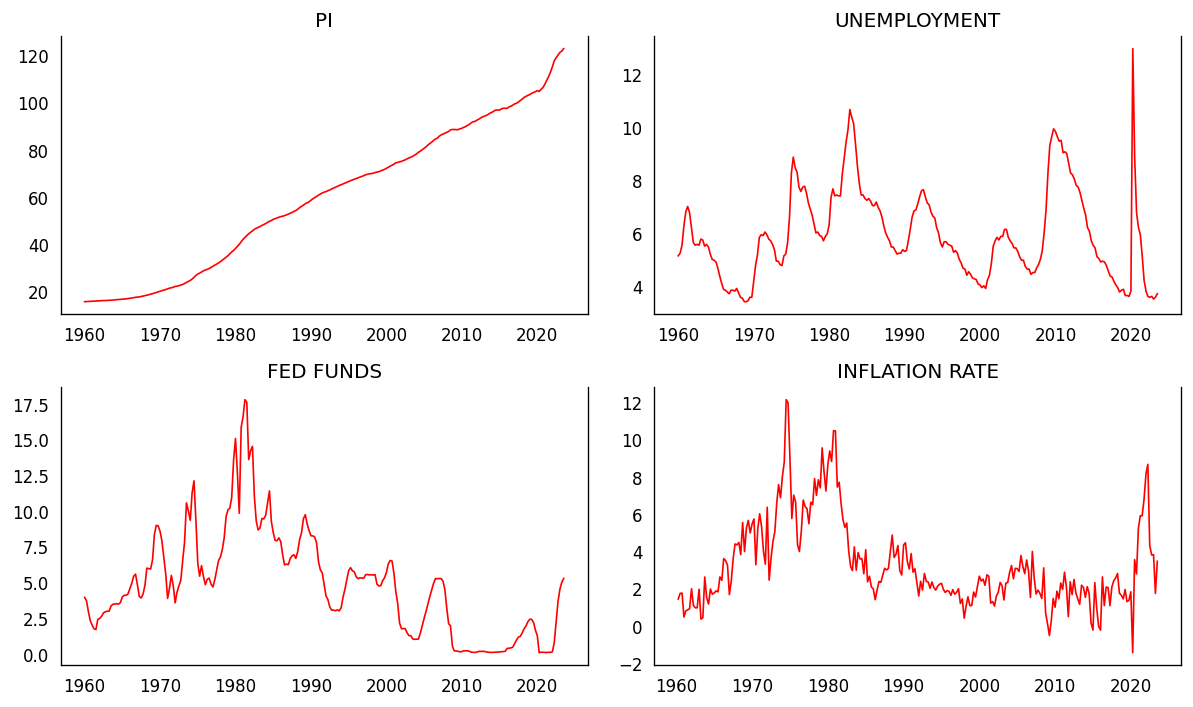

In [66]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    data = merged_df[merged_df.columns[i]]
    ax.plot(merged_df.index,data, color='red', linewidth=1)
    # Decorations
    ax.set_title(merged_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout();

#### 3. We will start by estimating a basic AR forecast for each variable. Divide the data into a training set and testing set. We will use 1960-2009 to train the model and test it on data from 2010-2023.

In [16]:
merged_df = merged_df.reset_index()

In [17]:
train_data = merged_df[merged_df['DATE'] <= '2009-12-31']
test_data = merged_df[(merged_df['DATE'] >= '2010-01-01') & (merged_df['DATE'] <= '2023-12-31')]

print("Train Data",train_data)
print("Test Data",test_data)

Train Data            DATE      PI  UNEMPLOYMENT  FED FUNDS  INFLATION RATE
0    1960-01-01  15.402      5.133333   3.931319             NaN
1    1960-04-01  15.457      5.233333   3.695055        1.425842
2    1960-07-01  15.524      5.533333   2.937500        1.730095
3    1960-10-01  15.592      6.266667   2.296196        1.748299
4    1961-01-01  15.610      6.800000   1.987556        0.461509
..          ...     ...           ...        ...             ...
195  2008-10-01  88.511      6.866667   0.505326        0.678457
196  2009-01-01  88.536      8.266667   0.184444        0.112964
197  2009-04-01  88.418      9.300000   0.178022       -0.533472
198  2009-07-01  88.474      9.633333   0.154348        0.253262
199  2009-10-01  88.798      9.933333   0.118370        1.462161

[200 rows x 5 columns]
Test Data            DATE       PI  UNEMPLOYMENT  FED FUNDS  INFLATION RATE
200  2010-01-01   89.018      9.833333   0.133889        0.989788
201  2010-04-01   89.431      9.633333   0.

In [18]:
train_data.isnull().sum()

DATE              0
PI                0
UNEMPLOYMENT      0
FED FUNDS         0
INFLATION RATE    1
dtype: int64

In [19]:
train_data = train_data.dropna()

In [20]:
train_data.isnull().sum()

DATE              0
PI                0
UNEMPLOYMENT      0
FED FUNDS         0
INFLATION RATE    0
dtype: int64

In [21]:
# AR Forecasting for PI
# Training the AR model
model = AutoReg(train_data['PI'], lags=1)  # Assuming lags=1 for simplicity
model_fit = model.fit()

# Forecasting
merged_df['PI_Forecast'] = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
# AR Forecasting for Inflation Rate
# Training the AR model
model = AutoReg(train_data['INFLATION RATE'], lags=1)  # Assuming lags=1 for simplicity
model_fit = model.fit()

# Forecasting
merged_df['Inf_Forecast'] = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
# AR Forecasting for Unemployment
# Training the AR model
model2 = AutoReg(train_data['UNEMPLOYMENT'], lags=1)  # Assuming lags=1 for simplicity
model_fit2 = model2.fit()

# Forecasting
merged_df['Unmp_Forecast'] = model_fit2.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
# AR Forecasting for Fed Funds Rate
# Training the AR model
model3 = AutoReg(train_data['FED FUNDS'], lags=1)  # Assuming lags=1 for simplicity
model_fit3 = model3.fit()

# Forecasting
merged_df['Fed_Forecast'] = model_fit3.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
merged_df

,DATE,PI,UNEMPLOYMENT,FED FUNDS,INFLATION RATE,PI_Forecast,Inf_Forecast,Unmp_Forecast,Fed_Forecast
0,1960-01-01,15.402,5.133333,3.931319,NaN,NaN,NaN,NaN,NaN
1,1960-04-01,15.457,5.233333,3.695055,1.425842,NaN,NaN,NaN,NaN
2,1960-07-01,15.524,5.533333,2.937500,1.730095,NaN,NaN,NaN,NaN
3,1960-10-01,15.592,6.266667,2.296196,1.748299,NaN,NaN,NaN,NaN
4,1961-01-01,15.610,6.800000,1.987556,0.461509,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
250,2022-07-01,118.980,3.566667,2.182935,4.312965,115.229184,3.521586,9.447997,4.617545
251,2022-10-01,120.115,3.600000,3.653370,3.797682,115.772901,3.522725,9.440667,4.645886
252,2023-01-01,121.264,3.500000,4.514556,3.808148,116.318017,3.523758,9.433401,4.673210
253,2023-04-01,121.789,3.566667,4.988132,1.728021,116.864537,3.524693,9.426199,4.699552


#### 4. Using the plot_pacf function, create partial autocorrelation (PACF) plots for each of the 3 variables (note: put a semicolon at the end of the line to stop it from showing graphs twice). Which lags does it appear have significance?

<Figure size 1000x400 with 0 Axes>

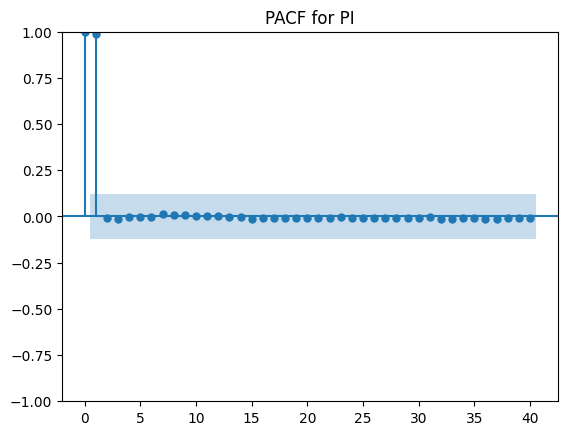

<Figure size 1000x400 with 0 Axes>

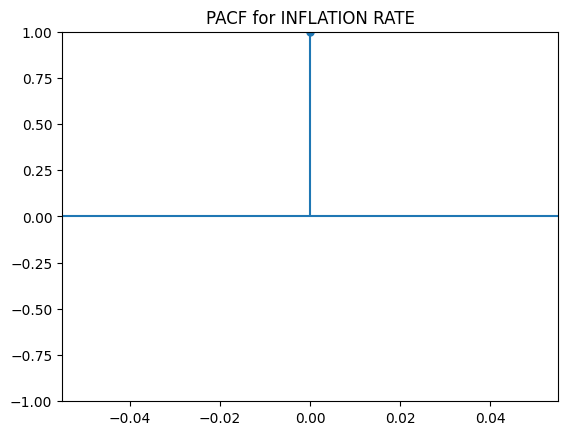

<Figure size 1000x400 with 0 Axes>

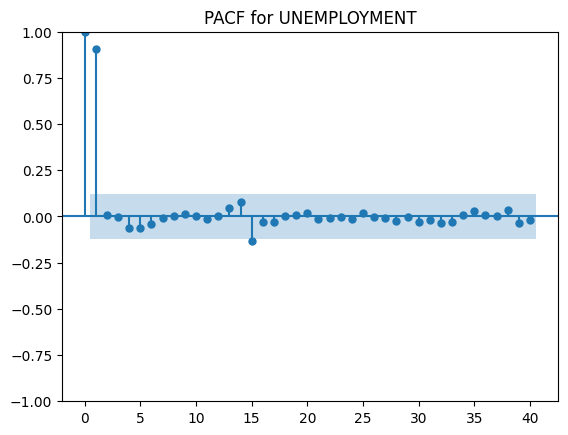

<Figure size 1000x400 with 0 Axes>

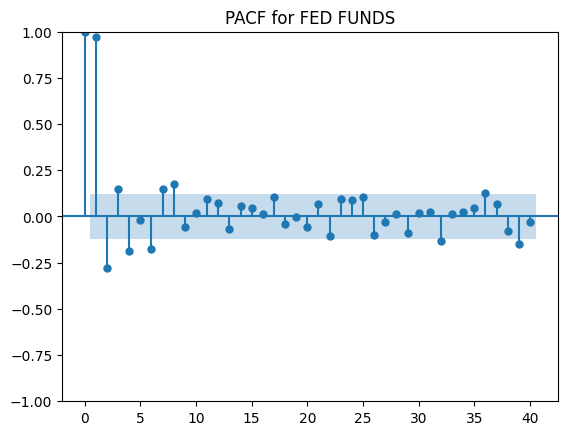

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

# Create PACF plots for each variable
variables = ['PI','INFLATION RATE', 'UNEMPLOYMENT', 'FED FUNDS']

for variable in variables:
    plt.figure(figsize=(10, 4))
    plot_pacf(merged_df[variable], lags=40, title=f'PACF for {variable}')
    plt.show();

#### Pattern:
Significant correlations at the first or second lag, followed by correlations that are not significant.

#### Indicating:
An autoregressive term in the data. The number of significant correlations indicate the order of the autoregressive term.

#### Interpretation of PACF plots:
- PI: Indicates an order of 2 lags for the AR model
- Inflation Rate: Indicates 0 number of lags. 
- Unemployment: Note that the first 2 lag values are statistically significant, whereas partial autocorrelations for all other lags are not statistically significant. This suggests a possible AR(2) model for these data.
- Fed Funds Rate: Indicates an order of 8 lags for the AR model.

#### 5. Now use the ar_select_order method to have statsmodels estimate the optimal number of lags (may want to look at the statsmodels documentation for the correct syntax). Do the lags roughly match what you thought based on the PACF plots?

In [108]:
variables = ['PI','INFLATION RATE', 'UNEMPLOYMENT', 'FED FUNDS']
for variable in variables:
    order = ar_select_order(train_data[variable], maxlag=12, ic='aic')
    optimal_lag = order.ar_lags
    print(f"Optimal lag order for {variable}: {optimal_lag}")

Optimal lag order for PI: [1, 2, 3, 4, 5, 6, 7, 8]
Optimal lag order for INFLATION RATE: [1, 2, 3]
Optimal lag order for UNEMPLOYMENT: [1, 2]
Optimal lag order for FED FUNDS: [1, 2, 3, 4, 5, 6, 7, 8]


C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-

Compared to the PACF plots above, we have got similar results for the optimal lag order for the variables "Unemployment" (2) and "Feds Funds Rate" (8). 

#### Alternative Method

In [59]:
mod = VAR(train_data.diff()[1:])

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [112]:
sorted_order = mod.select_order(maxlags = 20)
sorted_order.summary()

,AIC,BIC,FPE,HQIC
0,-5.530,-5.459,0.003964,-5.501
1,-8.574,-8.216*,0.0001890,-8.429
2,-8.723,-8.079,0.0001629,-8.462*
3,-8.833,-7.903,0.0001460,-8.456
4,-8.830,-7.615,0.0001466,-8.337
5,-8.869,-7.367,0.0001413,-8.260
6,-8.857,-7.069,0.0001435,-8.132
7,-8.971,-6.898,0.0001285,-8.130
8,-9.044*,-6.685,0.0001201*,-8.088
9,-8.989,-6.344,0.0001279,-7.916


A good model has the lowest scores for the above metrics. Looking at AIC and FPE values, we can see that 8 lags is associated with the lowest scores. Hence, we can use that to build the model further.

In [29]:
merged_df.index

RangeIndex(start=0, stop=255, step=1)

#### 6. Using the optimal lags, estimate and plot a forecast from 2010 to 2023 for each variable. You should first estimate the model using only the training data and then compare the forecast to the actual data. How well does your forecast match the data? Was it better or worse than you expected?

In [30]:
# Assuming 'DATE' is in string format, convert it to datetime
train_data['DATE'] = pd.to_datetime(train_data['DATE'])
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])

In [31]:
# Set 'DATE' as the index
train_data.set_index('DATE', inplace=True)
merged_df.set_index('DATE', inplace=True)

In [80]:
variables = train_data[['PI','INFLATION RATE','UNEMPLOYMENT','FED FUNDS']]
optimal_lags = {'PI': 8, 'INFLATION RATE': 3, 'UNEMPLOYMENT': 2, 'FED FUNDS': 8}

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The ind

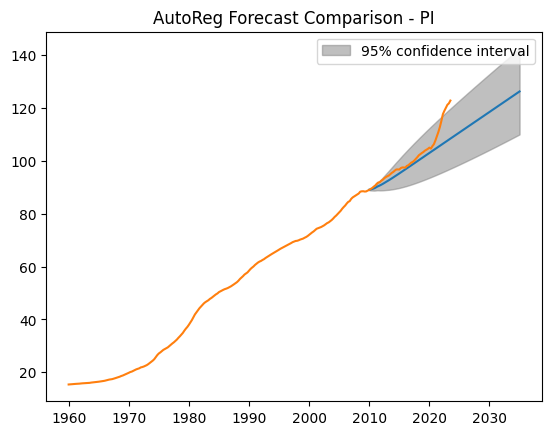

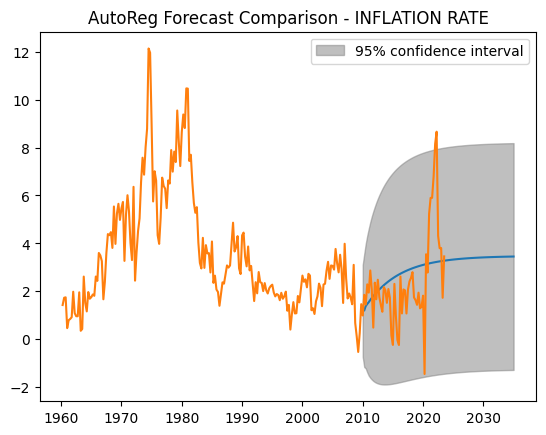

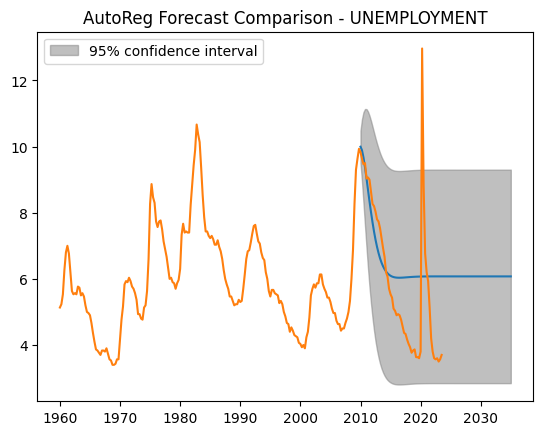

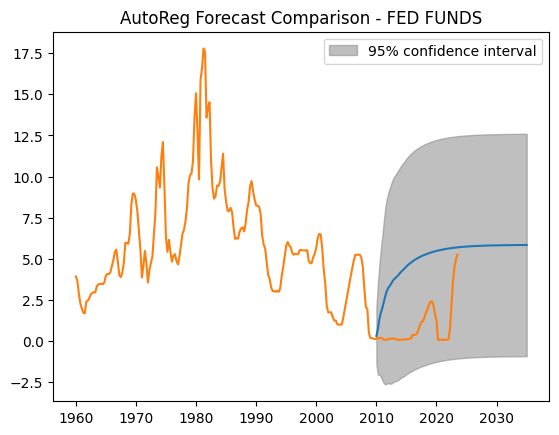

In [90]:
for variable, lag in optimal_lags.items():
    model1 = AutoReg(train_data[variable], lags=lag)
    model_fit = model1.fit()
    model_fit.plot_predict(start=len(train_data),end=len(train_data) + 100);
    plt.plot(merged_df[variable]);
    plt.title(f'AutoReg Forecast Comparison - {variable}')
plt.legend()
plt.show()

The prediction for PI seems better than other variable predictions since it has a narrower confidence interval. However, the trend of the prediction does look promising for all variables.

#### 7. Now extend your forecast forward. Re-estimate the model using the full data set and then predict 2 years forward from the end of the data. How confident are you in the forecasts?

In [36]:
merged_df.isnull().sum()

PI                  0
UNEMPLOYMENT        0
FED FUNDS           0
INFLATION RATE      1
PI_Forecast       200
Inf_Forecast      200
Unmp_Forecast     200
Fed_Forecast      200
dtype: int64

In [37]:
new_data = merged_df[['PI','INFLATION RATE','UNEMPLOYMENT','FED FUNDS']]

In [38]:
new_data.head()

,PI,INFLATION RATE,UNEMPLOYMENT,FED FUNDS
DATE,,,,
1960-01-01,15.402,NaN,5.133333,3.931319
1960-04-01,15.457,1.425842,5.233333,3.695055
1960-07-01,15.524,1.730095,5.533333,2.937500
1960-10-01,15.592,1.748299,6.266667,2.296196
1961-01-01,15.610,0.461509,6.800000,1.987556


In [39]:
new_data.dtypes

PI                float64
INFLATION RATE    float64
UNEMPLOYMENT      float64
FED FUNDS         float64
dtype: object

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

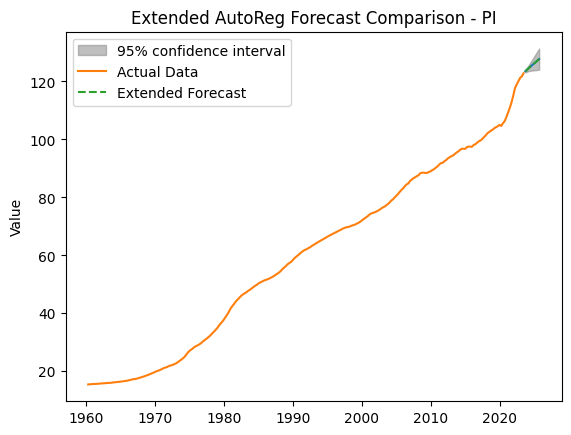

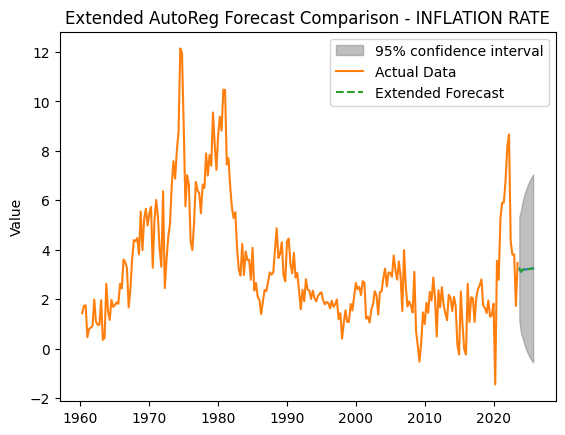

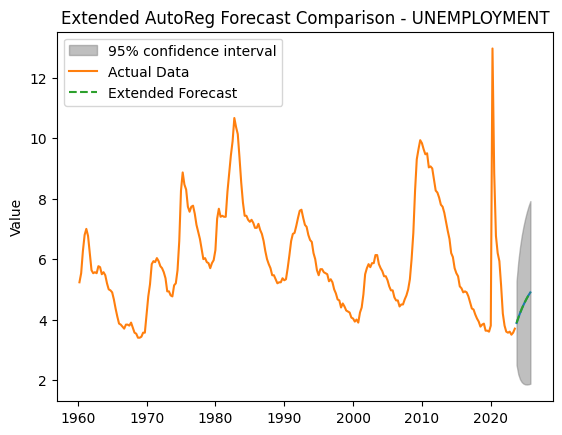

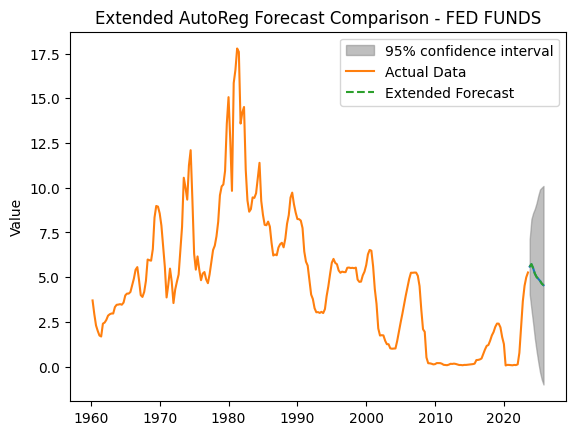

In [91]:
for new, lag in optimal_lags.items():
    # Estimate AutoReg model using optimal lag on the full dataset
    model_full = AutoReg(new_data[new], lags=lag)
    model_fit_full = model_full.fit()
    model_fit_full.plot_predict(start=len(new_data),end=len(new_data) + 8);
    # Predict 2 years forward from the end of the data
    forecast_full = model_fit_full.predict(start=len(new_data), end=len(new_data) + 8)

    # Plotting
    plt.plot(new_data.index, new_data[new], label= f'Actual Data')
    plt.plot(forecast_full.index, forecast_full, label= f'Extended Forecast', linestyle='dashed')

    plt.title(f'Extended AutoReg Forecast Comparison - {new}')

    plt.ylabel('Value')
    plt.legend()
plt.show()

As we can see, the extended forecast line seems to be predicting the variables accurately given the past trend. Also, the PI confidence interval has become narrower while for the other variables it has become broader. 

In [41]:
new_data = new_data.dropna()

In [134]:
new_data = new_data.drop(['PI'], axis = 1)

#### 8. Now we will turn to estimating the VAR model. To start, we will estimate it only on the sample studied in the original paper: 1960-2000. Run the following code to estimate the VAR and plot impulse response graphs:

model = VAR(df)

results = model.fit(4)

irf = results.irf(24)

fig = irf.plot(orth=True,signif=0.1)

#### Where 4 is the number of lags to be used in the VAR and 24 is the number of periods to forecast following a shock (matching the parameters used in the original paper)

In [135]:
train = new_data[new_data.index <= '2000-12-31']
print("Train Data",train)

Train Data             INFLATION RATE  UNEMPLOYMENT  FED FUNDS
DATE                                               
1960-04-01        1.425842      5.233333   3.695055
1960-07-01        1.730095      5.533333   2.937500
1960-10-01        1.748299      6.266667   2.296196
1961-01-01        0.461509      6.800000   1.987556
1961-04-01        0.793575      7.000000   1.733516
...                    ...           ...        ...
1999-10-01        2.095419      4.066667   5.304022
2000-01-01        2.656670      4.033333   5.677692
2000-04-01        2.396426      3.933333   6.271978
2000-07-01        2.497327      4.000000   6.519457
2000-10-01        2.165626      3.900000   6.474891

[163 rows x 3 columns]


C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


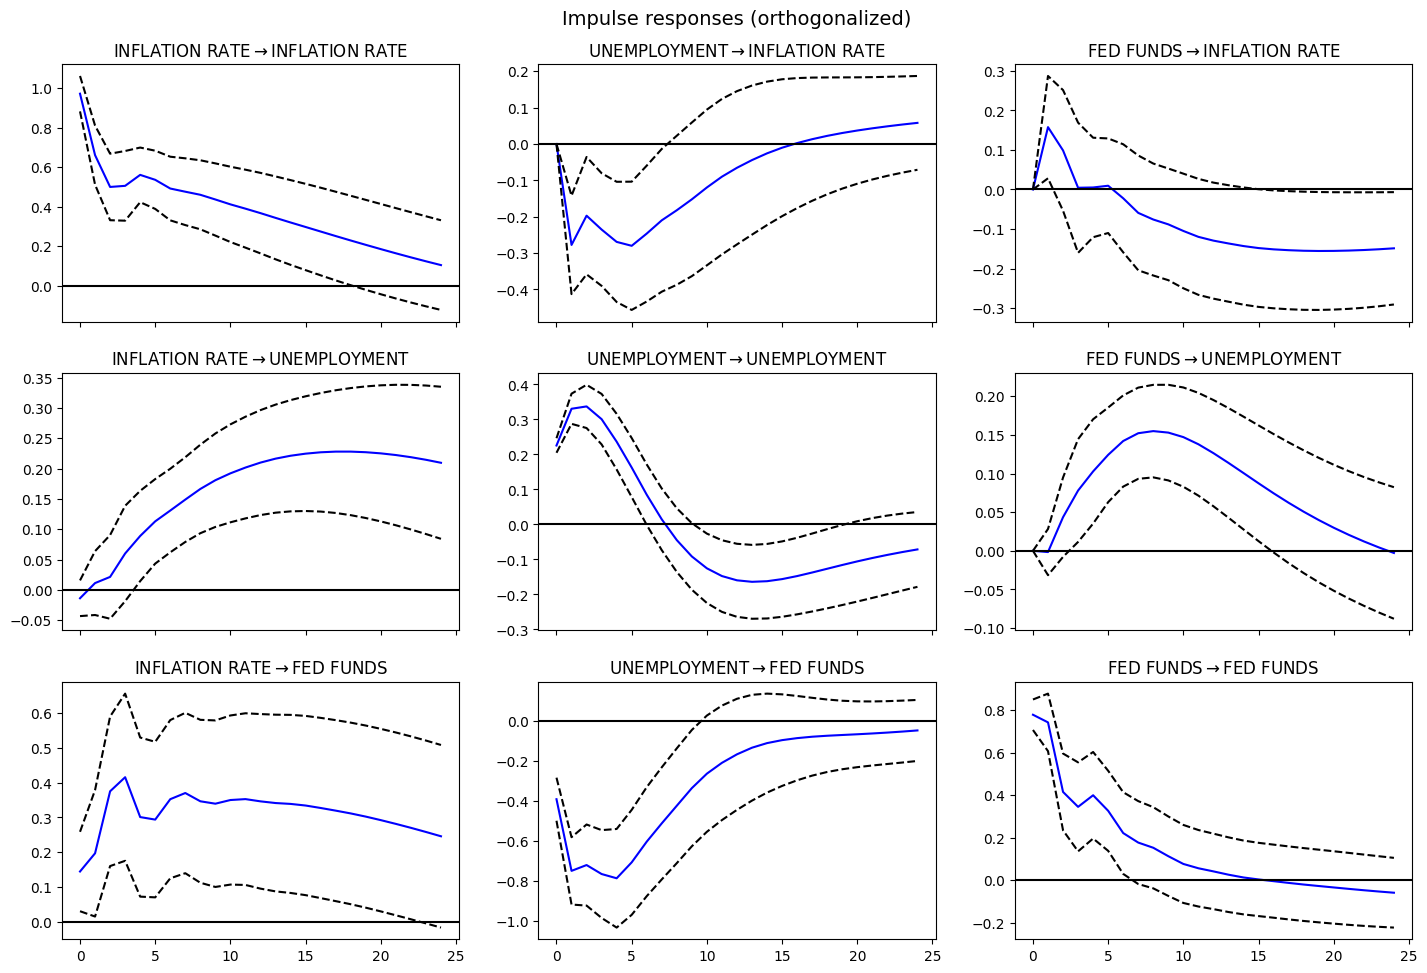

In [136]:
model = VAR(train)
results = model.fit(4)
irf = results.irf(24)
fig = irf.plot(orth=True,signif=0.1, figsize = (15,10))


Impulse responses trace out the response of current and future values of each of the variables to a one-unit increase in the current value of one of the VAR errors, assuming that this error returns to zero in subsequent periods and that all other
errors are equal to zero.

The first row shows the effect of an unexpected 1 percentage point increase in Inflation Rate on all four variables, as it works through the recursive VAR system with the coefficients estimated from actual data. The second row shows the effect of an unexpected increase of 1 percentage point in the Unemployment rate and the third row shows the corresponding effect for the Fed Funds rate.

Also plotted are (+-) 1 standard error bands, which yield an approximate 66 percent confidence
interval for each of the impulse responses. 

#### 9. Now we will estimate a factor error variance decomposition (FEVD). Use the following code:

fevd = results.fevd(12)

fevd.summary()

#### Compare the values you get to those in Table 1 of the paper (mine were close but not identical).You can also plot a graph of the FEVD using: fevd.plot();

FEVD for INFLATION RATE
      INFLATION RATE  UNEMPLOYMENT  FED FUNDS
0           1.000000      0.000000   0.000000
1           0.931174      0.052036   0.016790
2           0.915378      0.065162   0.019460
3           0.901449      0.081974   0.016577
4           0.887558      0.098444   0.013999
5           0.874397      0.113373   0.012231
6           0.867029      0.121761   0.011210
7           0.863760      0.124904   0.011336
8           0.862443      0.125423   0.012134
9           0.862308      0.124249   0.013442
10          0.862676      0.121831   0.015494
11          0.863029      0.118743   0.018228

FEVD for UNEMPLOYMENT
      INFLATION RATE  UNEMPLOYMENT  FED FUNDS
0           0.003737      0.996263   0.000000
1           0.001975      0.998008   0.000017
2           0.002804      0.990336   0.006860
3           0.011632      0.967166   0.021202
4           0.027248      0.931612   0.041140
5           0.049591      0.883180   0.067229
6           0.076709      0.82476

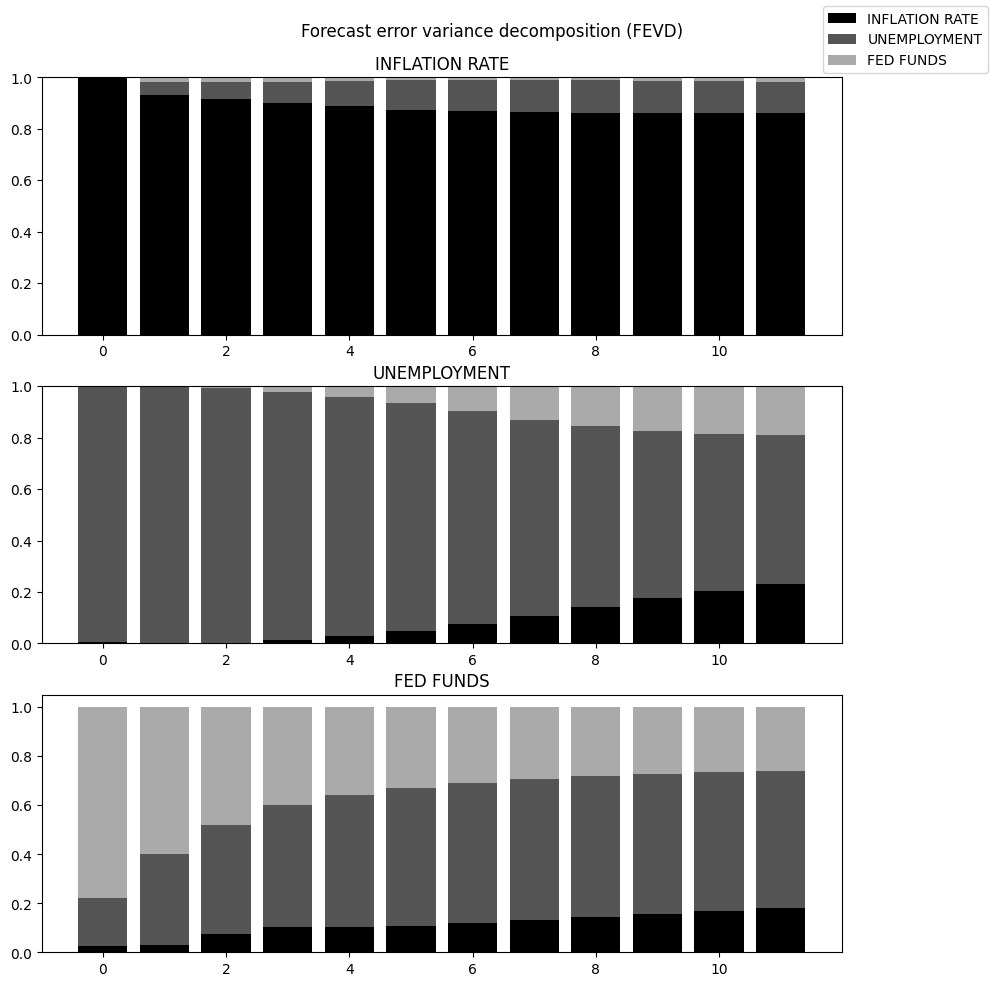

In [138]:
# Estimate Factor Error Variance Decomposition (FEVD) for 12 periods
fevd = results.fevd(12)

# Display summary of the FEVD
fevd.summary()

# Plot the FEVD
fevd.plot();


#### Inflation Rate:
- The first row indicates that about 100% of the forecast error variance in the inflation rate is explained by its own innovations. As we move to subsequent lags, we see a similar pattern where the proportion explained by its own innovations decreases, and the contributions from other variables increase. By the 11th lag, around 86% of the forecast error variance in the inflation rate is explained by its own innovations.

#### Unemployment:
- The first row indicates that almost 99% of the forecast error variance in unemployment is explained by its own innovations. As we move to subsequent lags, the proportion explained by its own innovations decreases, and the contributions from other variables increase. By the 11th lag, around 57% of the forecast error variance in unemployment is explained by its own innovations.

#### Fed Funds Rate:
- The first row indicates that around 77% of the forecast error variance in the Fed Funds rate is explained by its own innovations. As we move to subsequent lags, the proportion explained by its own innovations decreases, and the contributions from other variables increase. By the 11th lag, around 25% of the forecast error variance in the Fed Funds rate is explained by its own innovations.

#### CONCLUSION:
- As compared to the table 1, 14% of Inflation rate is explained by the rest of the variables (close to 18% in the table), 43% of Unemployment is explained Inflation rate and Fed Funds rate (34% in table1) and 75% of Fed Funds rate is explained by the rest (as compared to 75% in table1)

#### 10. Finally, we will determine whether each variable Granger causes the others. In general, we can determine whether var1 causes var2 using:

results.test_causality('var2', ['var1'], kind='f').summary()

#### Or if you just want the p-value:

results.test_causality('var2', ['var1'], kind=‘f').pvalue

#### Calculate whether each variable Granger causes either of the others and compare your results to those in Table 1 of the paper (I couldn’t get the exact same p-values but I did get the same reject or fail to reject decision for each pair)


In [48]:
variables = ['PI','INFLATION RATE', 'UNEMPLOYMENT', 'FED FUNDS']

for i in range(len(variables)):
    for j in range(len(variables)):
        if i != j:  # Avoid testing a variable against itself
            cause_variable = variables[i]
            effect_variable = variables[j]
            
            # Perform Granger causality test
            result = results.test_causality(effect_variable, [cause_variable], kind='f')
            
            # Print results
            print(f"Granger causality test: {cause_variable} -> {effect_variable}")
            print(result.summary())
            print(f"P-value: {result.pvalue}")


Granger causality test: PI -> INFLATION RATE
Granger causality F-test. H_0: PI does not Granger-cause INFLATION RATE. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.8985          2.388   0.464 (4, 568)
----------------------------------------------
P-value: 0.4644740853307132
Granger causality test: PI -> UNEMPLOYMENT
Granger causality F-test. H_0: PI does not Granger-cause UNEMPLOYMENT. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.489          2.388   0.204 (4, 568)
----------------------------------------------
P-value: 0.2039947987562915
Granger causality test: PI -> FED FUNDS
Granger causality F-test. H_0: PI does not Granger-cause FED FUNDS. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
------------------

Granger-causality statistics examine whether lagged values ofone variable help to predict another variable.

PI helps to predict Fed Funds rate but does not predict inflation rate and unemployment. Inflation rate does not help to predict either of the variables. Whereas, Unemployment explains the prediction of Fed Funds rate and Fed Funds rate in turn helps to predict Unemployment.

#### 11. Repeat steps 7-10 using the full sample rather than just the 1960-2000 period. What differences do you notice?

In [98]:
new_data = new_data.dropna()

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473

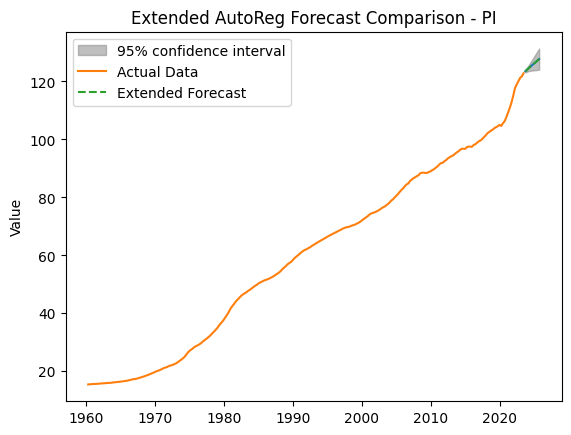

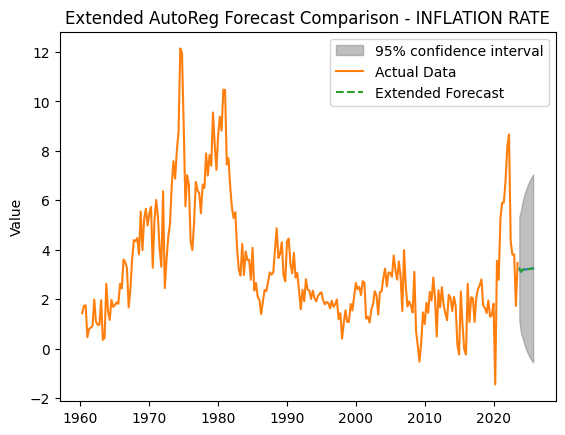

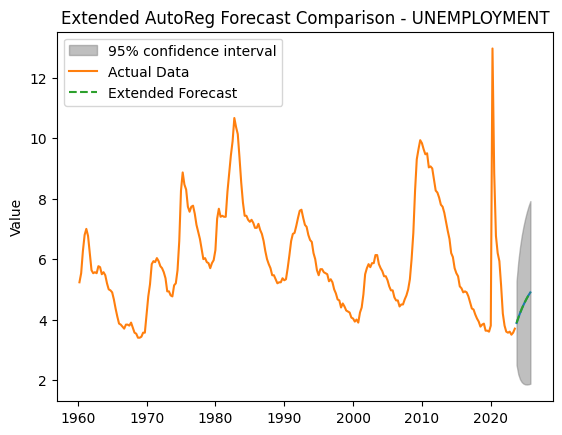

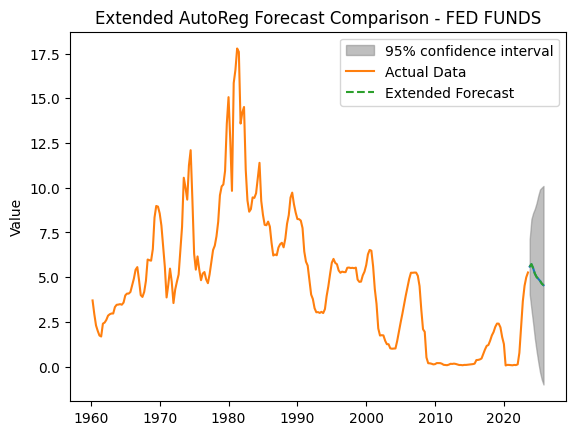

In [100]:
for new, lag in optimal_lags.items():
    # Estimate AutoReg model using optimal lag on the full dataset
    model_full = AutoReg(new_data[new], lags=lag)
    model_fit_full = model_full.fit()
    model_fit_full.plot_predict(start=len(new_data),end=len(new_data) + 8);
    # Predict 2 years forward from the end of the data
    forecast_full = model_fit_full.predict(start=len(new_data), end=len(new_data) + 8)

    # Plotting
    plt.plot(new_data.index, new_data[new], label= f'Actual Data')
    plt.plot(forecast_full.index, forecast_full, label= f'Extended Forecast', linestyle='dashed')

    plt.title(f'Extended AutoReg Forecast Comparison - {new}')

    plt.ylabel('Value')
    plt.legend()
plt.show()

#### The 2 year forecast still remains the same as shown before.

C:\Users\akudu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


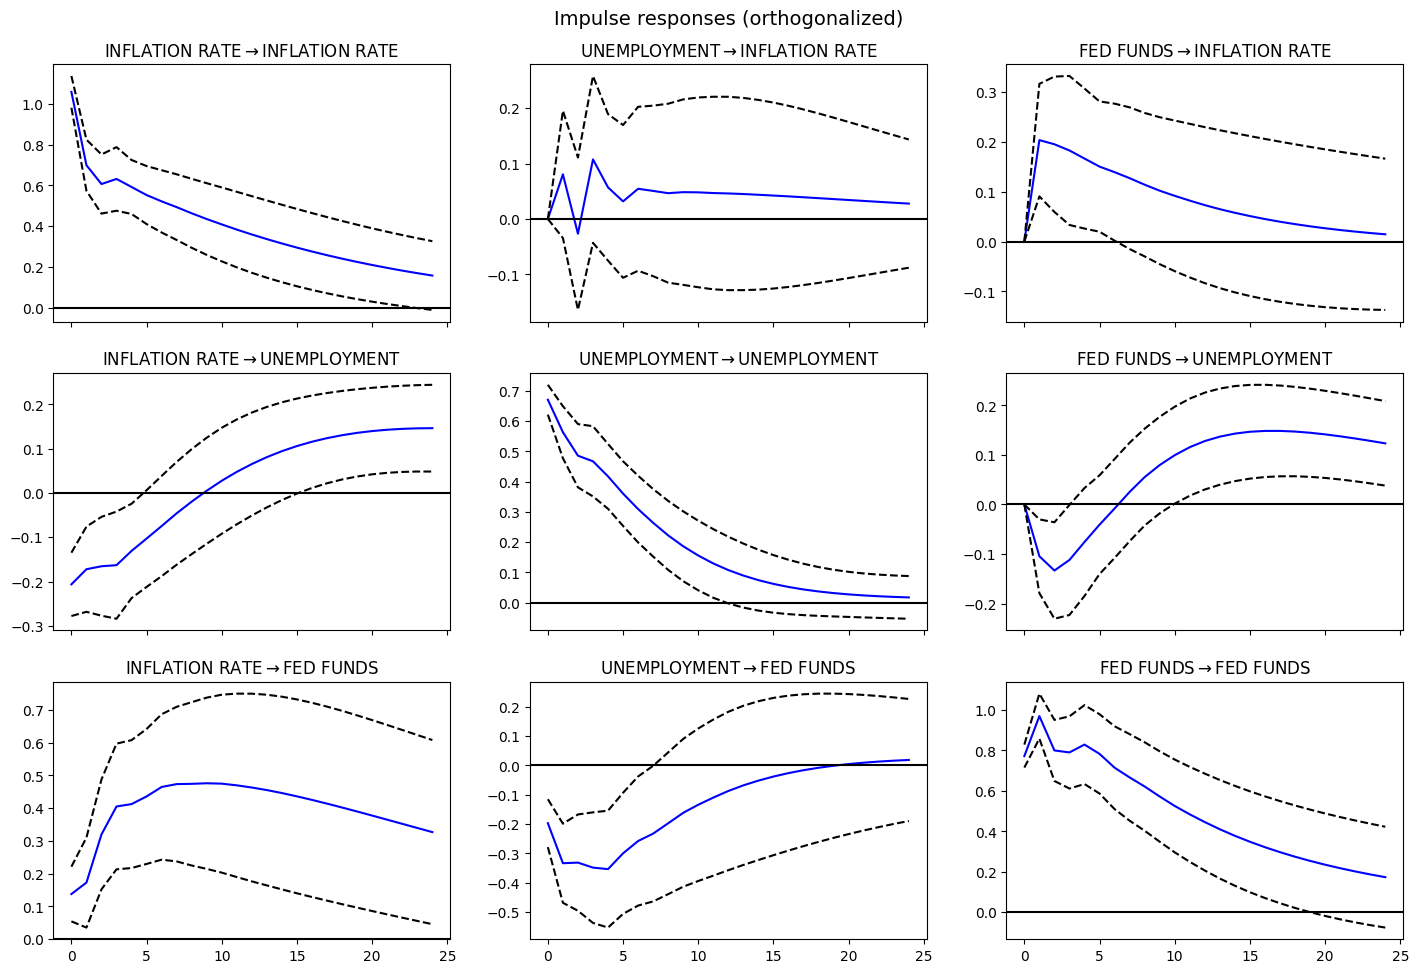

In [139]:
model2 = VAR(new_data)
results2 = model2.fit(4)
irf2 = results2.irf(24)
fig = irf2.plot(orth=True,signif=0.1, figsize = (15,10))


#### There is a very slight difference in the impulse response plots. Majorly, the standard error bands have inflated (greater than 66%).

FEVD for INFLATION RATE
      INFLATION RATE  UNEMPLOYMENT  FED FUNDS
0           1.000000      0.000000   0.000000
1           0.971220      0.003900   0.024880
2           0.958173      0.003473   0.038354
3           0.947731      0.007450   0.044819
4           0.943958      0.007586   0.048456
5           0.942376      0.007123   0.050501
6           0.940871      0.007368   0.051761
7           0.940035      0.007534   0.052431
8           0.939698      0.007641   0.052661
9           0.939573      0.007830   0.052598
10          0.939587      0.008037   0.052376
11          0.939700      0.008242   0.052058

FEVD for UNEMPLOYMENT
      INFLATION RATE  UNEMPLOYMENT  FED FUNDS
0           0.086376      0.913624   0.000000
1           0.084857      0.902306   0.012838
2           0.087970      0.886698   0.025332
3           0.090791      0.879551   0.029658
4           0.090298      0.880119   0.029583
5           0.089006      0.882883   0.028111
6           0.087133      0.88627

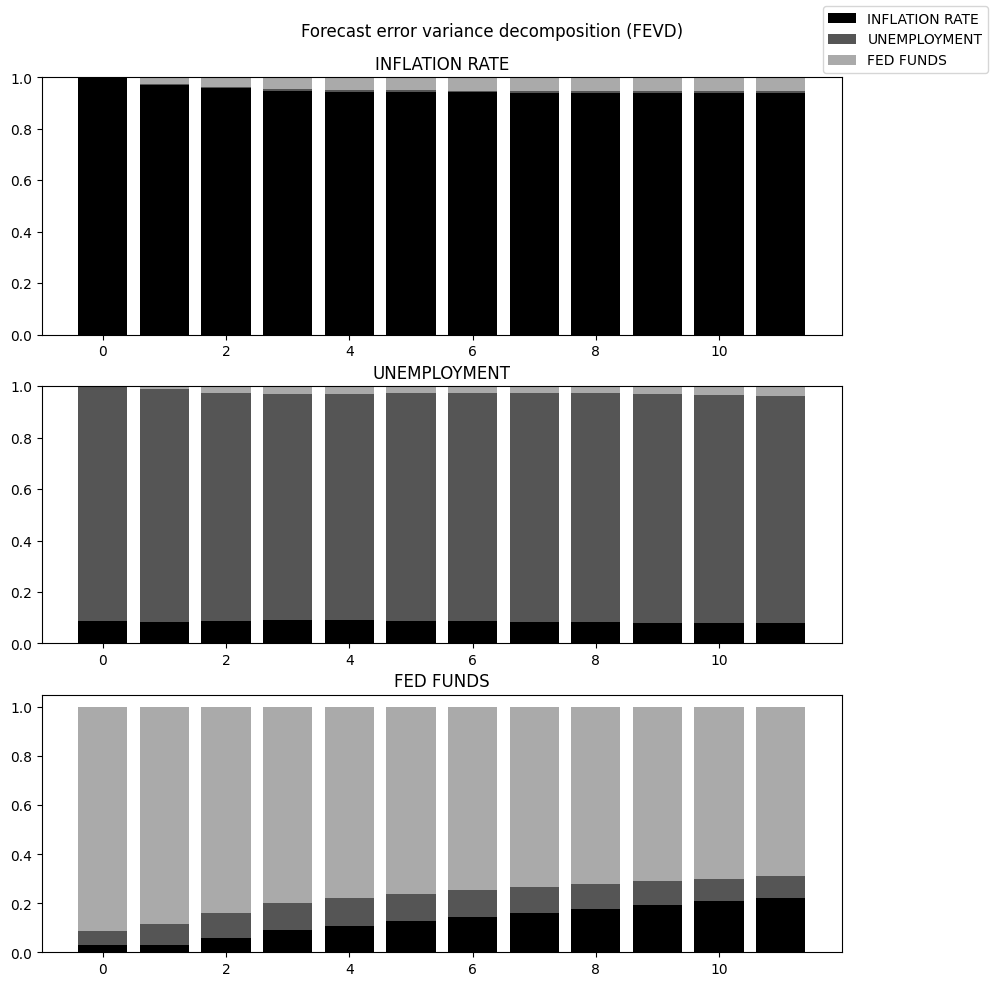

In [141]:
# Estimate Factor Error Variance Decomposition (FEVD) for 12 periods
fevd2 = results2.fevd(12)

# Display summary of the FEVD
fevd2.summary()

# Plot the FEVD
fevd2.plot();


#### Inflation Rate:
- The first row indicates that about 100% of the forecast error variance in the inflation rate is explained by its own innovations.
As we move to subsequent lags, the contribution from its own innovations decreases, and the contributions from other variables increase.
By the 11th lag, around 93% of the forecast error variance in the inflation rate is explained by its own innovations.

#### Unemployment:
- The first row indicates that around 91% of the forecast error variance in unemployment is explained by its own innovations.
As we move to subsequent lags, the proportion explained by its own innovations decreases, and the contributions from other variables increase.
By the 11th lag, around 88% of the forecast error variance in unemployment is explained by its own innovations.

#### Fed Funds Rate:
- The first row indicates that around 91% of the forecast error variance in the Fed Funds rate is explained by its own innovations.
As we move to subsequent lags, the contribution from its own innovations decreases, and the contributions from other variables increase.
By the 11th lag, around 68% of the forecast error variance in the Fed Funds rate is explained by its own innovations.

#### CONCLUSION:
- As compared to the table 1, 7% of Inflation rate is explained by the rest of the variables (not close to 18% in the table), 12% of Unemployment is explained Inflation rate and Fed Funds rate (nott close to 34% in table1) and 32% of Fed Funds rate is explained by the rest (as compared to 75% in table1)

In [97]:
variables1 = ['PI','INFLATION RATE', 'UNEMPLOYMENT', 'FED FUNDS']

for i in range(len(variables1)):
    for j in range(len(variables1)):
        if i != j:  # Avoid testing a variable against itself
            cause_variable = variables1[i]
            effect_variable = variables1[j]
            
            # Perform Granger causality test
            result3 = results2.test_causality(effect_variable, [cause_variable], kind='f')
            
            # Print results
            print(f"Granger causality test: {cause_variable} -> {effect_variable}")
            print(result3.summary())
            print(f"P-value: {result3.pvalue}")


Granger causality test: PI -> INFLATION RATE
Granger causality F-test. H_0: PI does not Granger-cause INFLATION RATE. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.587          2.381   0.176 (4, 932)
----------------------------------------------
P-value: 0.17558777612679263
Granger causality test: PI -> UNEMPLOYMENT
Granger causality F-test. H_0: PI does not Granger-cause UNEMPLOYMENT. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.560          2.381   0.037 (4, 932)
----------------------------------------------
P-value: 0.03728689417362646
Granger causality test: PI -> FED FUNDS
Granger causality F-test. H_0: PI does not Granger-cause FED FUNDS. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------

#### Before taking full model :

PI helps to predict Fed Funds rate but does not predict inflation rate and unemployment. Inflation rate does not help to predict either of the variables. Whereas, Unemployment explains the prediction of Fed Funds rate and Fed Funds rate in turn helps to predict Unemployment.

#### After taking full model :

PI helps to predict Unemployment. Inflation rate does not help to predict either of the variables. Unemployment explains the prediction of PI but does not explain Inflation rate or Fed Funds rate. Whereas, Feds Funds rate helps to predict both Inflation rate and Unemployment.

#### FINAL CONCLUSION:

The prediction model in question 7 is better than the results we got for question 11

#### 12. Collect all of your graphs and statistics and combine them into a single nicely formatted pdf. Think of this as practice for putting together a research paper. You may want to use LaTex to format the final output, but Word or another word processor is also fine.